# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

In [2]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision as T
import torchvision.transforms as transforms
import torchsummary
from PIL import Image
from os import listdir
from os.path import exists
import re
import sys
import pickle

In [2]:
# from google.colab import drive
# # Mount Google Drive
# drive.mount('/content/drive')
# %cd "/content/drive/DeepLearning/P3/"

In [3]:

data_path = 'Data/'
results_path = 'Results/'

seed_value = 10
torch.manual_seed(seed_value)

save_figure = True
run_train = True
run_test = True
use_gpu = True # Use GPU if available

device = torch.device(
    'cuda:0' if use_gpu and torch.cuda.is_available() else
    'mps' if use_gpu and torch.backends.mps.is_available() else
    'cpu'
)

In [4]:
def plot_acc_loss(fig, axes, accuracies, losses, epochs, save_figure, plot_mode="both"):
    if plot_mode != "both" and plot_mode != "smooth" and plot_mode != "real":
        print("plot_mode options: both, smooth or both")
        return
    
    window = 100
    # smoothed_accuracies = np.convolve(train_accuracies, np.ones(window)[::-1], mode="same")

    
    
    epoch_range = np.arange(epochs + 1)
    
    if plot_mode != "smooth":
        axes[0].plot(accuracies, label="Real accuracies", color="#68CDFF")
    
    if plot_mode != "real":
        smoothed_accuracies = scipy.signal.savgol_filter(accuracies, window, 5)
        axes[0].plot(smoothed_accuracies, label="Smoothed accuracies", color="blue")
    
    axes[0].set_xlim(None)
    axes[0].set_xticks(epoch_range * 256, epoch_range)
    axes[0].set_title("Train accuracy at each step")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_ylim((0, 100))
    axes[0].legend()
    axes[0].grid()

    if plot_mode != "smooth":
        axes[1].plot(losses, label="Real losses", color="#68CDFF")
    
    if plot_mode != "real":
        smoothed_losses = scipy.signal.savgol_filter(losses, window, 5)
        axes[1].plot(smoothed_losses, label="Smoothed losses", color="blue")
    
    axes[1].set_title("Loss at each step")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_ylim((0, None))
    axes[1].legend()
    axes[1].grid()

    return fig

In [5]:
# Setting the model name
if run_train:
    files = listdir(results_path + "models/")
    models = list(filter(lambda name: ".ckpt" in name, files))
    pattern = re.compile("model_(\d+).ckpt")
    indices = [int(pattern.search(model).group(1)) for model in models]
    if len(models) == 0:
        indices = [0]
    train_model_name = "model_" + str(max(indices) + 1)
    test_model_name = train_model_name
    print(f"Training model: {train_model_name}")


if run_test and not run_train:
    test_model_name = input("Introduce the model name that you want to test: ")
    while not exists(results_path + "models/" + test_model_name + ".ckpt"):
        print("Model does not exist")
        test_model_name = input("Introduce the model name that you want to test: ")

Training model: model_2


# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:

- 1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.

- 1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html

- 1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.

- 1.4 Whatever you consider...


1. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

## Defining some useful classes and functions

In [6]:
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

In [7]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3
        
        self.fc = nn.Linear(8 * 8 * 32, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        return out 

In [8]:
def train_cnn(model, train_loader, epochs, optimizer, criterion=nn.CrossEntropyLoss()):
    torch.manual_seed(seed_value)

    model.train() # Set the model in train mode
    total_step = len(train_loader)
    accuracies = []
    train_losses = []
    
    # Iterate over epochs
    for epoch in range(epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            model.train()
            total = 0 # Total number of images of the batch
            correct = 0 # Correct predictions of the model
            
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_losses.append(loss.item())
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                model.eval()
                _, predicted = torch.max(outputs.data, 1)

                # compare with the ground-truth
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                accuracies.append(100 * correct / total)
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, epochs, i+1, total_step, loss.item()))

    return accuracies, train_losses

# Test funcion
def test(CNN, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [11]:
tr = transforms.Compose([
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat', tr)


# network 
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

num_classes = 10
CNN = ConvNet()


# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(), lr = learning_rate)

# Device configuration (choose GPU if it is available )
num_epochs = 5

CNN = CNN.to(device)

## Initial results

Training with 73257 images
Epoch [1/5], Step [100/287], Loss: 1.1063
Epoch [1/5], Step [200/287], Loss: 0.7286
Epoch [2/5], Step [100/287], Loss: 0.4620
Epoch [2/5], Step [200/287], Loss: 0.4514
Epoch [3/5], Step [100/287], Loss: 0.4186
Epoch [3/5], Step [200/287], Loss: 0.5217
Epoch [4/5], Step [100/287], Loss: 0.6579
Epoch [4/5], Step [200/287], Loss: 0.3635
Epoch [5/5], Step [100/287], Loss: 0.4679
Epoch [5/5], Step [200/287], Loss: 0.4085


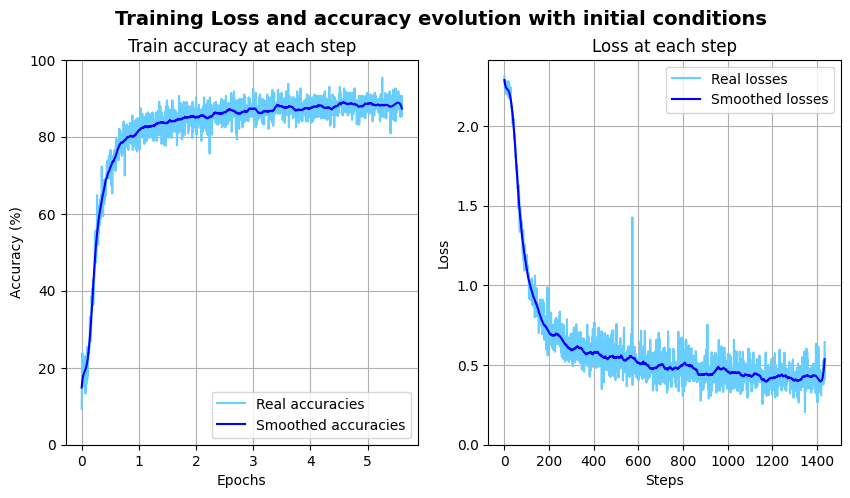

In [11]:
if run_train:
    print(f"Training with {len(SVHNTrain)} images")
    train_accuracies, train_losses = train_cnn(CNN, train_loader, num_epochs, optimizer, criterion)
    
    fig2, axes = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle("Training Loss and accuracy evolution with initial conditions", fontsize=14, fontweight="bold")
    plot_acc_loss(fig2, axes, train_accuracies, train_losses, num_epochs, save_figure, plot_mode="both")
    if save_figure: plt.savefig(f"{results_path}/fig2.png", dpi=300)
    plt.show()

    # Save the model checkpoint
    torch.save(CNN.state_dict(), results_path + "models/" + train_model_name + ".ckpt")

In [12]:
if run_test:
    CNN.load_state_dict(torch.load(results_path + "models/" + test_model_name + ".ckpt"))
    # Load test dataset
    SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat', tr)
    test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)
    CNN.eval() # Set the model in evaluation mode
    
    
    test_acc = test(CNN, test_loader)

    print('Test Accuracy of the model on the {} test images: {} %'.format(len(SVHNTest), test_acc))

    with open(results_path + "models/" + test_model_name + ".txt", "a") as results_txt:
        results_txt.write(f"Test accuracy: {test_acc}\n")


Test Accuracy of the model on the 26032 test images: 86.06714812538414 %


In [14]:
# with open(results_path + "models/" + test_model_name + ".txt", "a") as results_txt:
#     results_txt.write(f"Epochs: {num_epochs}\n")
#     results_txt.write(f"Loss function: {criterion}\n")
#     results_txt.write(f"Optimizer: {optimizer}\n")
#     sys.stdout = results_txt # FIXME: This is 
#     torchsummary.summary(CNN, (3, 32, 32))


# sys.stdout = sys.__stdout__


## Trying different learning rates ($\alpha$)

In [13]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]
lr_accuracies = {}
lr_losses = {}
num_epochs = 5
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat', tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                            batch_size=256, 
                                            shuffle=True)

for lr in learning_rates:
    curr_model = ConvNet()
    curr_model.to(device)
    curr_model.train()
    curr_criterion = nn.CrossEntropyLoss()
    curr_optimizer = torch.optim.Adam(curr_model.parameters(), lr = lr)
    
    print(f"LR: {lr}. Training with {len(SVHNTrain)} images")
    train_accuracies, train_losses = train_cnn(curr_model, train_loader, num_epochs, curr_optimizer, curr_criterion)
    
    
    lr_accuracies[lr] = train_accuracies
    lr_losses[lr] = train_losses

    # Save the model checkpoint
    # torch.save(CNN.state_dict(), results_path + "models/" + train_model_name + ".ckpt")
        
    # CNN.load_state_dict(torch.load(results_path + "models/" + test_model_name + ".ckpt"))
    # Load test dataset
    
    curr_model.eval() # Set the model in evaluation mode
    
    
    test_acc = test(curr_model, test_loader)

    print('LR: {}. Test Accuracy of the model on the {} test images: {} %'.format(lr, len(SVHNTest), test_acc))

            # with open(results_path + "models/" + test_model_name + ".txt", "a") as results_txt:
            #     results_txt.write(f"Test accuracy: {test_acc}\n")



LR: 0.1. Training with 73257 images
Epoch [1/5], Step [100/287], Loss: 2.2302
Epoch [1/5], Step [200/287], Loss: 2.2399
Epoch [2/5], Step [100/287], Loss: 2.2235
Epoch [2/5], Step [200/287], Loss: 2.2374
Epoch [3/5], Step [100/287], Loss: 2.2427
Epoch [3/5], Step [200/287], Loss: 2.2293
Epoch [4/5], Step [100/287], Loss: 2.2866
Epoch [4/5], Step [200/287], Loss: 2.2237
Epoch [5/5], Step [100/287], Loss: 2.2489
Epoch [5/5], Step [200/287], Loss: 2.2654
LR: 0.1. Test Accuracy of the model on the 26032 test images: 19.587430854333128 %
LR: 0.01. Training with 73257 images
Epoch [1/5], Step [100/287], Loss: 1.9261
Epoch [1/5], Step [200/287], Loss: 1.1058
Epoch [2/5], Step [100/287], Loss: 0.7845
Epoch [2/5], Step [200/287], Loss: 1.0101
Epoch [3/5], Step [100/287], Loss: 0.8796
Epoch [3/5], Step [200/287], Loss: 0.8324
Epoch [4/5], Step [100/287], Loss: 1.0751
Epoch [4/5], Step [200/287], Loss: 0.7821
Epoch [5/5], Step [100/287], Loss: 0.8597
Epoch [5/5], Step [200/287], Loss: 0.9497
LR: 

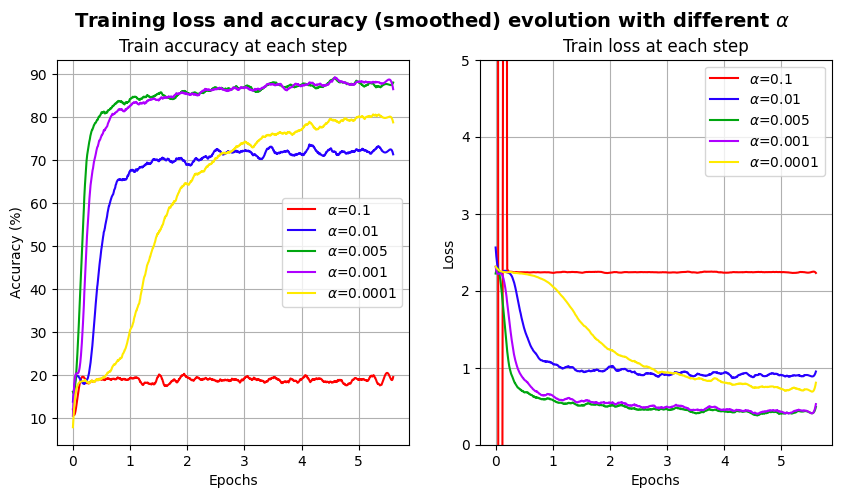

In [19]:
colors = ["#ff0000", "#2700ff", "#00A610", "#af00ff", "#FFEA00"]
lighter_colors = ["#FF5E5E", "#9784FF", "#57A65F", "#DB8CFF", "#FFF47B"]


ncols = 2
fig3, axes = plt.subplots(1, ncols, figsize=(10, 5))
plt.suptitle("Training loss and accuracy (smoothed) evolution with different $\\alpha$", fontsize=14, fontweight="bold")
for i, lr in enumerate(learning_rates):
    acc = lr_accuracies[lr]
    loss = lr_losses[lr]
    window = 100
    # smoothed_accuracies = np.convolve(train_accuracies, np.ones(window)[::-1], mode="same")

    for col in range(ncols):
        if col == 0:
            val = acc
        elif col == 1:
            val = loss
        epoch_range = np.arange(num_epochs + 1)
        # axes[col].plot(val, label="Real accuracies", color=lighter_colors[i])
        smoothed = scipy.signal.savgol_filter(val, window, 5)
        axes[col].plot(smoothed, label=f"$\\alpha$={lr}", color=colors[i])
        axes[col].set_xlim(None)
        axes[col].set_xticks(epoch_range * 256, epoch_range)
        axes[col].legend()
        axes[col].grid()

    axes[0].set_title("Train accuracy at each step")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[1].set_title("Train loss at each step")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_ylim((0, 5))

if save_figure: plt.savefig(f"{results_path}/fig3.png", dpi=300)
plt.show()

## Trying different batch sizes

In [13]:
batch_sizes = [16, 32, 64, 128, 256, 512]
learning_rate = 0.001
btch_accuracies = {}
btch_losses = {}
num_epochs = 5
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat', tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                            batch_size=256, 
                                            shuffle=True)

for batch in batch_sizes:
    curr_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                            batch_size=batch, 
                                            shuffle=True)
    curr_model = ConvNet()
    curr_model.to(device)
    curr_model.train()
    curr_criterion = nn.CrossEntropyLoss()
    curr_optimizer = torch.optim.Adam(curr_model.parameters(), lr = learning_rate)
    
    print(f"Batch size: {batch}. Training with {len(SVHNTrain)} images")
    train_accuracies, train_losses = train_cnn(curr_model, curr_train_loader, num_epochs, curr_optimizer, curr_criterion)
    
    
    btch_accuracies[batch] = train_accuracies
    btch_losses[batch] = train_losses

    # Save the model checkpoint
    # torch.save(CNN.state_dict(), results_path + "models/" + train_model_name + ".ckpt")
        
    # CNN.load_state_dict(torch.load(results_path + "models/" + test_model_name + ".ckpt"))
    # Load test dataset
    
    curr_model.eval() # Set the model in evaluation mode
    
    
    test_acc = test(curr_model, test_loader)

    print('Batch size: {}. Test Accuracy of the model on the {} test images: {} %'.format(batch, len(SVHNTest), test_acc))

            # with open(results_path + "models/" + test_model_name + ".txt", "a") as results_txt:
            #     results_txt.write(f"Test accuracy: {test_acc}\n")



Batch size: 16. Training with 73257 images
Epoch [1/5], Step [100/4579], Loss: 2.2480
Epoch [1/5], Step [200/4579], Loss: 1.2208
Epoch [1/5], Step [300/4579], Loss: 1.3999
Epoch [1/5], Step [400/4579], Loss: 1.2101
Epoch [1/5], Step [500/4579], Loss: 0.5051
Epoch [1/5], Step [600/4579], Loss: 1.0233
Epoch [1/5], Step [700/4579], Loss: 0.5287
Epoch [1/5], Step [800/4579], Loss: 0.5909
Epoch [1/5], Step [900/4579], Loss: 0.9501
Epoch [1/5], Step [1000/4579], Loss: 0.5156
Epoch [1/5], Step [1100/4579], Loss: 0.9235
Epoch [1/5], Step [1200/4579], Loss: 0.7897
Epoch [1/5], Step [1300/4579], Loss: 0.3242
Epoch [1/5], Step [1400/4579], Loss: 0.4574
Epoch [1/5], Step [1500/4579], Loss: 0.7554
Epoch [1/5], Step [1600/4579], Loss: 0.4924
Epoch [1/5], Step [1700/4579], Loss: 0.1879
Epoch [1/5], Step [1800/4579], Loss: 0.5460
Epoch [1/5], Step [1900/4579], Loss: 0.3868
Epoch [1/5], Step [2000/4579], Loss: 0.6574
Epoch [1/5], Step [2100/4579], Loss: 1.1470
Epoch [1/5], Step [2200/4579], Loss: 0.329

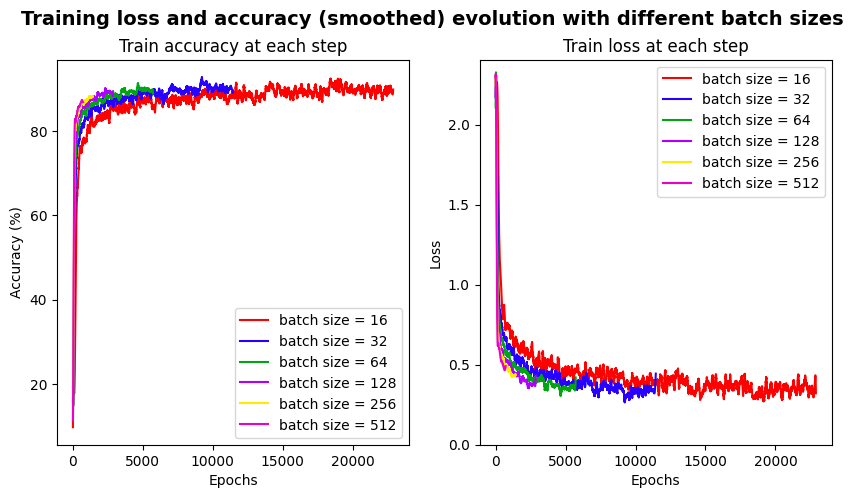

In [36]:
colors = ["#ff0000", "#2700ff", "#00A610", "#af00ff", "#FFEA00", "#EE00CB"]
lighter_colors = ["#FF5E5E", "#9784FF", "#57A65F", "#DB8CFF", "#FFF47B", "#EE60D9"]

ncols = 2
fig4, axes = plt.subplots(1, ncols, figsize=(10, 5))
plt.suptitle("Training loss and accuracy (smoothed) evolution with different batch sizes", fontsize=14, fontweight="bold")
for i, batch in enumerate(batch_sizes):
    acc = btch_accuracies[batch]
    loss = btch_losses[batch]
    window = 300
    # smoothed_accuracies = np.convolve(train_accuracies, np.ones(window)[::-1], mode="same")

    for col in range(ncols):
        if col == 0:
            val = acc
        elif col == 1:
            val = loss
        epoch_range = np.arange(num_epochs + 1)
        # axes[col].plot(val, label="Real accuracies", color=lighter_colors[i])
        smoothed = scipy.signal.savgol_filter(val, window, 5)
        axes[col].plot(smoothed, label=f"batch size = {batch}", color=colors[i])
        axes[col].set_xlim(None)
        # axes[col].set_xticks(epoch_range * batch_sizes[-1], epoch_range)
        axes[col].legend()
    

    axes[0].set_title("Train accuracy at each step")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[1].set_title("Train loss at each step")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_ylim((0, None))
    axes[0].grid()
    axes[1].grid()

if save_figure: plt.savefig(f"{results_path}/fig4.png", dpi=300)
plt.show()

## Training the network with the extended dataset

In [ ]:
# TODO: code 

## Applying some transformations

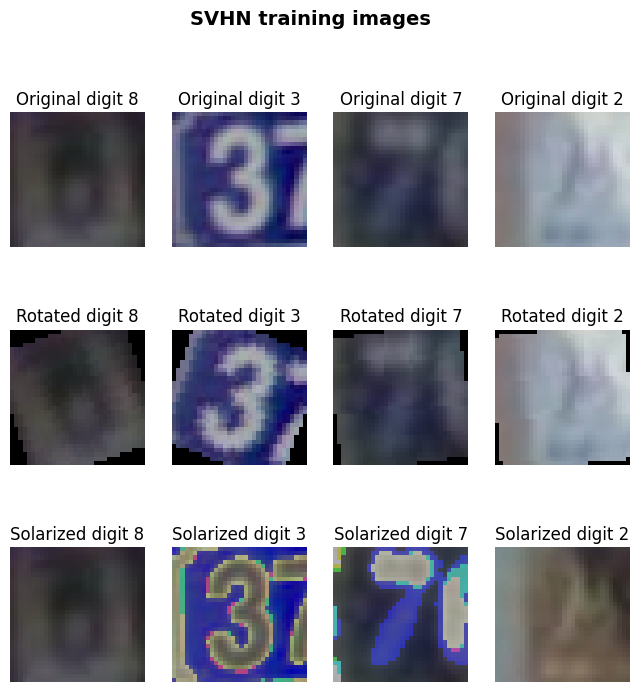

In [110]:
tr_plot = transforms.Compose([
        transforms.ToTensor(),
        ])

SVHNTrain_plot = SVHN(data_path+'/svhn/train_32x32.mat', tr_plot)


# network 
train_loader_plot = torch.utils.data.DataLoader(dataset=SVHNTrain_plot,
                                               batch_size=1, 
                                               shuffle=True)

num_images = 4
num_rows = 3

fig5, axes = plt.subplots(num_rows, num_images, figsize=(8, 8))
fig5.suptitle("SVHN training images", fontsize=14, fontweight="bold")
row = 0

original_images = []
rotated_images = []
solarized_images = []
count = 0
rotator = transforms.RandomRotation(degrees=(-25, 25))
solarize = transforms.RandomSolarize(threshold=0.3, p=0.8)
plotted_labels = []

for images, labels in train_loader_plot:
    plotted_labels.append(labels.item() + 1)
    original_images.append(images)
    rotated_images.append(rotator(images))
    solarized_images.append(solarize(images))
    count += 1
    if count >= 4: break



# axes[0].set_title("Original images")
for col, image in enumerate(original_images):
    axes[0, col].axis("off")
    axes[0, col].imshow(original_images[col][0].permute(1, 2, 0))
    axes[0, col].set_title(f"Original digit {plotted_labels[col]}")

for col, image in enumerate(original_images):
    axes[1, col].axis("off")
    axes[1, col].imshow(rotated_images[col][0].permute(1, 2, 0))
    axes[1, col].set_title(f"Rotated digit {plotted_labels[col]}")

for col, image in enumerate(original_images):
    axes[2, col].axis("off")
    axes[2, col].imshow(solarized_images[col][0].permute(1, 2, 0))
    axes[2, col].set_title(f"Solarized digit {plotted_labels[col]}")

if save_figure: plt.savefig(f"{results_path}/fig5.png", dpi=300)
plt.show()
    

In [111]:
tr = transforms.Compose([
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomSolarize(threshold=0.3, p=0.8),
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat', tr)


# network 
transofrmed_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

num_classes = 10
transformed_model = ConvNet()


# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(transformed_model.parameters(), lr = learning_rate)

# Device configuration (choose GPU if it is available )
num_epochs = 5

transformed_model = transformed_model.to(device)

Training with 73257 images
Epoch [1/5], Step [100/287], Loss: 0.8417
Epoch [1/5], Step [200/287], Loss: 0.8327
Epoch [2/5], Step [100/287], Loss: 0.7567
Epoch [2/5], Step [200/287], Loss: 0.7952
Epoch [3/5], Step [100/287], Loss: 0.6689
Epoch [3/5], Step [200/287], Loss: 0.6090
Epoch [4/5], Step [100/287], Loss: 0.5285
Epoch [4/5], Step [200/287], Loss: 0.5648
Epoch [5/5], Step [100/287], Loss: 0.6707
Epoch [5/5], Step [200/287], Loss: 0.6296


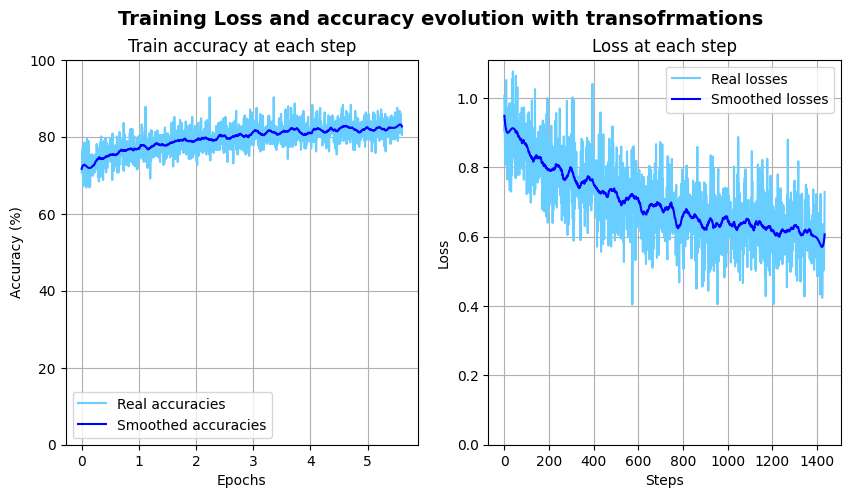

In [114]:
print(f"Training with {len(SVHNTrain)} images")
train_accuracies, train_losses = train_cnn(transformed_model, transofrmed_train_loader, num_epochs, optimizer, criterion)

fig6, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Training Loss and accuracy evolution with transofrmations", fontsize=14, fontweight="bold")
plot_acc_loss(fig6, axes, train_accuracies, train_losses, num_epochs, save_figure, plot_mode="both")
if save_figure: plt.savefig(f"{results_path}/fig6.png", dpi=300)
plt.show()

# Save the model checkpoint
torch.save(transformed_model.state_dict(), results_path + "models/" + train_model_name + ".ckpt")

In [115]:
transformed_model.load_state_dict(torch.load(results_path + "models/" + test_model_name + ".ckpt"))
# Load test dataset
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat', tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                            batch_size=256, 
                                            shuffle=True)
transformed_model.eval() # Set the model in evaluation mode


test_acc = test(transformed_model, test_loader)

print('Test Accuracy of the model on the {} test images: {} %'.format(len(SVHNTest), test_acc))

with open(results_path + "models/" + test_model_name + ".txt", "a") as results_txt:
    results_txt.write(f"Test accuracy: {test_acc}\n")


Test Accuracy of the model on the 26032 test images: 81.86078672403197 %


# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [ ]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [ ]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

In [ ]:
'''
1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.
  - MobileNet: https://arxiv.org/abs/1704.04861
  - MobileNet V2: https://arxiv.org/pdf/1801.04381.pdf
  - SqueezeNet: https://arxiv.org/abs/1602.07360
  - ShuffleNet: https://arxiv.org/abs/1707.01083
  - ESPNet V2: https://arxiv.org/abs/1811.11431
2. Train it and test it on SVHN using the provided code.
3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.
'''


## Sol. 2

### Define your own model and check the number of total parameters

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Mobilenet Style Architecture
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()
        self.linear = nn.Linear(32*32*3,num_classes)
        '''
        REPLACE WITH YOUR CODE HERE
        '''
                

                
    def forward(self, x):
        return self.linear(x.view(x.shape[0],-1))
        '''
        REPLACE WITH YOUR CODE HERE
        '''


model = MyModel(num_classes=10)
n_params = compute_model_params(model)
print("MyModel Parameters: " + str(n_params))



### Train your model on SVHN
It is not allowed to change training hyper-parameters such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [ ]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/P4/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2021/P4/Results/'

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [ ]:
#Train MyModel
my_model = MyModel()

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_net.ckpt', device=device)


### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [ ]:
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = MyModel()
my_net.load_state_dict(torch.load(results_path + 'my_net.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

# Ex. 3

In [ ]:
'''
1. Use the implemented architecture in the previous exercice to solve the transfer learning
   task provided in the examples.
2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.
2. Report the test accuracy in each case and discuss the results. 
'''

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [ ]:
# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL,
                                               batch_size=256, 
                                               shuffle=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)
# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9,
                                                  batch_size=64, 
                                                  shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [ ]:
#Train ResNet
resnet_tl = MyModel(num_classes=8)
#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(resnet_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_tl = resnet_tl.to(device)

losses_it = train(resnet_tl, tl_train_loader, optimizer, num_epochs=10, model_name='tl_mynet_svhn.ckpt', device=device)


### Fine-tune the pretrained network with the small dataset of 9s and 0s